# 1: Librerie
Importazione di tutte le librerie necessarie per la gestione del dataset, la costruzione del modello e l'apprendimento della rete.

* `tensorflow`: Funzioni di creazione del modello, e di gestione della fase di training.
* `pandas`: Funzioni di apertura e parsing del dataset.
* `matplotlib`: Funzioni di gestione dei grafici, per la visualizzazione dei risultati in fase di training.

In [2]:
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers     as layers
import tensorflow.keras.models     as models
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder as le

## Variabili globali
* `num_layers`: Configurazione degli strati della rete. Aggiungendo e rimuovendo neuroni, è possibile modificare la rete.
* `num_epochs`: Numero di epoche di training del modello (usato anche nella fase di valutazione nel test set).

In [3]:
net_layers = [ [32, 'relu'] for _ in range(2) ] + [[64, 'relu'] for _ in range(10)] + [ [32, 'relu'] ]
num_epochs = 25                                  # Number of epochs

# 2: Dataset
Importazione del dataset e divisione delle istanze per validation, training e testing.

## Obiettivo del modello
Classificazione dell'età di un *abalone*, a seconda delle misure fisiche effettuate.

* Elementi: **4177** istanze
* Features disponibili: **8** colonne
* Classificazione: **3** classi

In [4]:
try:
  
  dataset = pd.read_csv("./Dataset.csv") # load the dataset

  dataset['Sex'] = le().fit_transform(dataset['Sex']) # label encoding for column 'Sex'

  # One-hot encoding for column 'Age'
  column     = 'Age'
  dataset    = pd.get_dummies(dataset, columns = [column], prefix = column)
  dummy_cols = [col for col in dataset.columns if col.startswith(f'{column}_')]

  Y = dataset[dummy_cols]
  X = dataset.drop(columns = dummy_cols)

  # First split: 70% train, 30% combined validation and test
  X_train, X_combined, Y_train, Y_combined = train_test_split(X, Y, test_size = 0.3, random_state = 42)

  # Second split: 65% validation, 35% test from the 30% combined set
  X_val, X_test, Y_val, Y_test = train_test_split(X_combined, Y_combined, test_size = 0.35, random_state = 42)

  print("Training set shape:  ", X_train.shape, Y_train.shape)
  print("Validation set shape:", X_val.shape, Y_val.shape)
  print("Test set shape:      ", X_test.shape, Y_test.shape)
except FileNotFoundError:
  
  print("Errore, file non trovato")

Training set shape:   (2923, 8) (2923, 3)
Validation set shape: (815, 8) (815, 3)
Test set shape:       (439, 8) (439, 3)


# 3: Creazione del modello
Generazione di un modello di rete neurale.

In [5]:
model = models.Sequential([layers.Input(shape = (X_train.shape[1],))]) # Input layer

for layer in net_layers: # Add hidden layers
    model.add(layers.Dense(layer[0], activation = layer[1]))
    model.add(layers.Dropout(0.2)) # Dropout layer to prevent overfitting
    model.add(layers.BatchNormalization()) # Batch normalization layer

model.add(layers.Dense(Y_train.shape[1], activation='softmax')) # Output layer

model.summary() # Print the model summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 46,019 (179.76 KB)

 Trainable params: 44,547 (174.01 KB)

 Non-trainable params: 1,472 (5.75 KB)

## Compilazione e training del modello generato

In [6]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss      = 'categorical_crossentropy', 
    metrics   = ['accuracy', 'Precision', 'Recall']
)

history = model.fit(
    X_train, Y_train,
    epochs          = num_epochs, # Number of epochs
    batch_size      = 32, # Batch size
    validation_data = (X_val, Y_val)
)

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - Precision: 0.3656 - Recall: 0.2686 - accuracy: 0.3544 - loss: 1.3884 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4687 - val_loss: 0.9592
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - Precision: 0.4656 - Recall: 0.3025 - accuracy: 0.4518 - loss: 1.0886 - val_Precision: 0.6964 - val_Recall: 0.2589 - val_accuracy: 0.4687 - val_loss: 0.8640
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - Precision: 0.4958 - Recall: 0.3458 - accuracy: 0.4878 - loss: 0.9548 - val_Precision: 0.4824 - val_Recall: 0.1509 - val_accuracy: 0.4822 - val_loss: 0.8118
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Precision: 0.5106 - Recall: 0.3871 - accuracy: 0.5054 - loss: 0.8635 - val_Precision: 0.5453 - val_Recall: 0.4798 - val_accuracy: 0.5301 - val_loss: 0.7729
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - Precision: 0.5118 - Recall: 0.4302 - accuracy: 0.5132 - loss: 0.8077 - val_Precision: 0.4581 - val_Rec

## Visualizzazione dei risultati

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7696 - Recall: 0.7696 - accuracy: 0.7696 - loss: 0.4936
Test set evaluation:
Loss:     0.5452
Accuracy: 0.7426


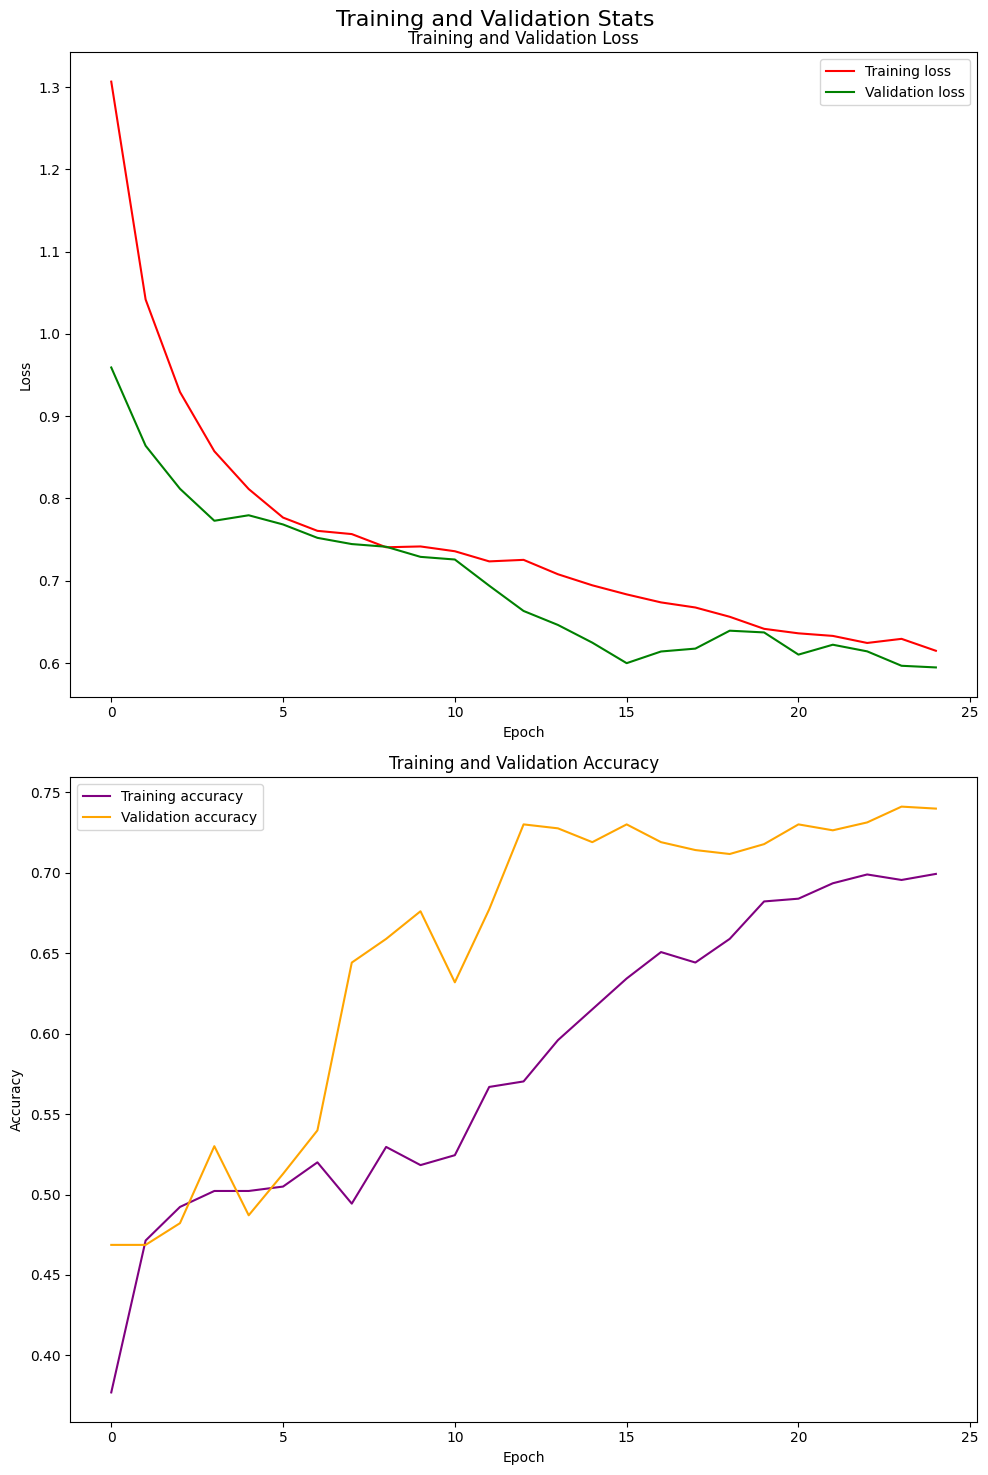

In [7]:
new_history = model.evaluate(X_test, Y_test, steps = num_epochs, return_dict = True) # Evaluate the model on the test set

print("Test set evaluation:") # this is probably not correct
print(f"Loss:     {new_history['loss']:.4f}")
print(f"Accuracy: {new_history['accuracy']:.4f}")

fig, plots = plt.subplots(2, 1, figsize = (10, 15)) # Create a figure with 2 subplots
fig.suptitle('Training and Validation Stats', fontsize = 16)

# Training and validation loss
plots[0].set_title('Training and Validation Loss')
plots[0].plot(history.history['loss'],     label = 'Training loss',   color = 'red')
plots[0].plot(history.history['val_loss'], label = 'Validation loss', color = 'green')
plots[0].set_xlabel('Epoch')
plots[0].set_ylabel('Loss')
plots[0].legend()

# Training and validation accuracy
plots[1].set_title('Training and Validation Accuracy')
plots[1].plot(history.history['accuracy'],     label = 'Training accuracy',   color = 'purple')
plots[1].plot(history.history['val_accuracy'], label = 'Validation accuracy', color = 'orange')
plots[1].set_xlabel('Epoch')
plots[1].set_ylabel('Accuracy')
plots[1].legend()


   


fig.tight_layout() # Adjust layout to prevent overlap
plt.show()         # Show the plots